In [1]:
#
# Author Jiabao Li
#
# Created on Mon May 27 2024
#
# Copyright (c) 2024 Loctek
#


In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from preprocess import make_dataset, scale_IR, make_dataset_ex
import torch.optim as optim
from model import *
from torch.utils.data import Dataset, DataLoader


In [3]:
class CustomDataset(Dataset):
    def __init__(self, distance_dataset, IR_dataset, ground_truth, filename_dataset):
        self.IR_dataset = IR_dataset
        self.distance_dataset = distance_dataset
        self.ground_truth = ground_truth
        self.filename_dataset = filename_dataset

    def __len__(self):
        return self.IR_dataset.shape[0]

    def __getitem__(self, idx):
        IR_data = self.IR_dataset[idx]
        distance_data = self.distance_dataset[idx]
        label = self.ground_truth[idx]
        # 将标签转换为one-hot编码
        label_one_hot = torch.zeros(LABEL_NUM)
        label_one_hot[label] = 1
        return IR_data, distance_data, label_one_hot, self.filename_dataset[idx]


In [4]:
g_modle_str = 'high'
# g_modle_str = 'low'
g_modle_extra_str = '3'



# trainset, testset = make_dataset()
trainset, testset = make_dataset_ex(g_modle_str)

# 创建数据集和数据加载器
train_dataset = CustomDataset(*trainset)
test_dataset = CustomDataset(*testset)

# 创建数据加载器
# USE_BACH = BATCH
USE_BACH = 32 # 自定义batch_size
train_dataloader = DataLoader(train_dataset, batch_size=USE_BACH, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=USE_BACH, shuffle=False)


distance length is 1549
IR length is 1549
gt length is 1549
Distance train dataset: torch.Size([37947, 14, 1])
IR train dataset: torch.Size([37947, 9, 64])
gt train dataset: 37947
test dataset has file amount:  torch.Size([310, 14, 1])


In [5]:
labels = trainset[2]
# 计算每个类别出现的次数
num_samples = len(labels)
num_classes = max(labels) + 1  # 假设类别标签从0开始且连续
class_counts = [labels.count(i) for i in range(num_classes)]

# 计算每个类别的权重，使用类别频率的倒数
weights = [num_samples / class_counts[i] if class_counts[i] > 0 else 0 for i in range(num_classes)]

# 转换为Tensor
weights_tensor = torch.tensor(weights).to(mydevice)
print(weights_tensor)

tensor([4.6384, 4.4181, 5.8371, 4.9507, 5.4125], device='cuda:0')


In [6]:

# 实例化网络
net = MyMLP().to(mydevice)
# net = MyCNN().to(mydevice)

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss(weight=weights_tensor)
optimizer = optim.Adam(net.parameters(), lr=0.002)


In [7]:
loss_history = []
print("if gpu=",torch.cuda.is_available())
# 训练循环示例
for epoch in range(40):
    running_loss = 0.0
    for i, (IR_data, distance_data, labels, _) in enumerate(train_dataloader, 0):
        IR_data = IR_data.to(mydevice)
        distance_data = distance_data.to(mydevice)
        labels = labels.to(mydevice)
        # 清零梯度
        optimizer.zero_grad()

        # 前向传播
        outputs = net(IR_data, distance_data)
        # 计算损失
        loss = criterion(outputs, labels)
        # 反向传播
        loss.backward()
        # 更新权重
        optimizer.step()

        # 打印统计信息
        running_loss += loss.cpu().item()
        if i % 20 == 19:  # 每10个批次打印一次
            loss_mean = running_loss / 20
            loss_history.append(loss_mean)
            print(f"[{epoch + 1}, {i + 1}] loss: {loss_mean:.3f}")
            running_loss = 0.0


if gpu= True
[1, 20] loss: 7.931
[1, 40] loss: 8.081
[1, 60] loss: 8.110
[1, 80] loss: 8.022
[1, 100] loss: 8.027
[1, 120] loss: 7.944
[1, 140] loss: 7.746
[1, 160] loss: 7.764
[1, 180] loss: 7.688
[1, 200] loss: 7.137
[1, 220] loss: 7.542
[1, 240] loss: 7.387
[1, 260] loss: 7.139
[1, 280] loss: 7.180
[1, 300] loss: 7.269
[1, 320] loss: 6.934
[1, 340] loss: 7.157
[1, 360] loss: 7.321
[1, 380] loss: 7.172
[1, 400] loss: 7.288
[1, 420] loss: 6.889
[1, 440] loss: 7.192
[1, 460] loss: 6.964
[1, 480] loss: 6.976
[1, 500] loss: 6.886
[1, 520] loss: 7.117
[1, 540] loss: 6.922
[1, 560] loss: 7.136
[1, 580] loss: 6.795
[1, 600] loss: 7.181
[1, 620] loss: 7.112
[1, 640] loss: 7.015
[1, 660] loss: 6.934
[1, 680] loss: 7.010
[1, 700] loss: 7.021
[1, 720] loss: 6.662
[1, 740] loss: 6.773
[1, 760] loss: 6.692
[1, 780] loss: 6.761
[1, 800] loss: 6.574
[1, 820] loss: 6.866
[1, 840] loss: 6.802
[1, 860] loss: 6.636
[1, 880] loss: 6.875
[1, 900] loss: 6.647
[1, 920] loss: 6.911
[1, 940] loss: 6.745
[1, 

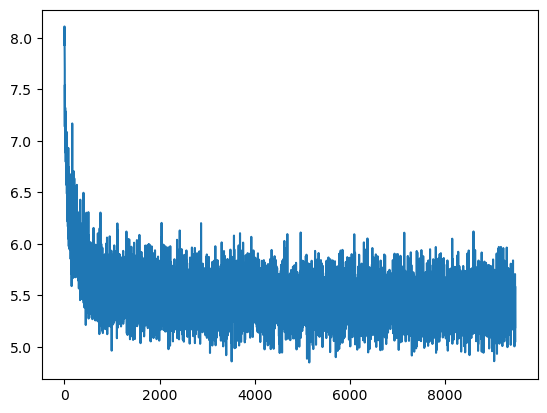

In [8]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import matplotlib.pyplot as plt

plt.plot(loss_history)
plt.show()

In [9]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

# 测试循环
true_labels = []
predicted_labels = []
filenames = []
with torch.no_grad():
    for i, (IR_data, distance_data, labels, filename) in enumerate(test_dataloader):
        IR_data = IR_data.to(mydevice)
        distance_data = distance_data.to(mydevice)

        outputs = net(IR_data, distance_data)
        outputs = outputs.cpu()

        _, predicted = torch.max(outputs.data, 1)
        _, gt = torch.max(labels.data, 1)
        
        true_labels.extend(gt.numpy())
        predicted_labels.extend(predicted.numpy())
        filenames += filename

# 计算性能指标
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='weighted', zero_division=1) # macro
recall = recall_score(true_labels, predicted_labels, average='weighted', zero_division=1)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}\n")

# 计算每个类别的精确度和召回率
precision_per_class = precision_score(true_labels, predicted_labels, average=None, zero_division=0)
recall_per_class = recall_score(true_labels, predicted_labels, average=None, zero_division=0)

# 打印结果
print("labels are ", ['idle', 'sit', 'sit2stand', 'stand', 'stand2sit'])
print(f"Precision per class: {precision_per_class}")
print(f"Recall per class: {recall_per_class}\n")

from sklearn.metrics import confusion_matrix

# 计算混淆矩阵
cm = confusion_matrix(true_labels, predicted_labels)

print("混淆矩阵:")
print(cm)

print("\n")

tmp_test_count = cm.sum()

# 无人判断为有人
idle_err_count  = (cm[1][0] + cm[2][0] + cm[3][0] + cm[4][0])
print(f"有人判断为无人的异常概率：{idle_err_count/tmp_test_count:.4f}")

no_idle_err_count  = (cm[0][1] + cm[0][2] + cm[0][3] + cm[0][4])
print(f"无人判断为有人的异常概率：{no_idle_err_count/tmp_test_count:.4f}")


if g_modle_str is 'low':
    # 若是低位模型 - 其他类型误识别为站
    low_err_count = (cm[0][3] + cm[1][3] + cm[2][3] + cm[4][3])
    print(f"其他类型误识别成站：{ low_err_count/tmp_test_count:.4f}")

if g_modle_str is 'high':
    # 若是高位模型 - 其他类型误识别为坐
    high_err_count = (cm[0][1] + cm[2][1] + cm[3][1] + cm[4][1])
    print(f"其他类型误识别成坐：{ high_err_count/tmp_test_count:.4f}")

Accuracy: 0.9258
Precision: 0.9326
Recall: 0.9258

labels are  ['idle', 'sit', 'sit2stand', 'stand', 'stand2sit']
Precision per class: [0.98333333 1.         0.98076923 0.86363636 0.83928571]
Recall per class: [1.         0.84375    0.87931034 0.95       0.95918367]

混淆矩阵:
[[59  0  0  0  0]
 [ 0 54  1  3  6]
 [ 0  0 51  7  0]
 [ 1  0  0 76  3]
 [ 0  0  0  2 47]]


有人判断为无人的异常概率：0.0032
无人判断为有人的异常概率：0.0000
其他类型误识别成坐：0.0000


In [10]:
# 找出被错误分类的样本
misclassified_samples = [filenames[i] for i in range(len(filenames)) if true_labels[i] != predicted_labels[i]]
print("被错误分类的样本:", misclassified_samples)

被错误分类的样本: ['../data/high-position-sit2stand/newwld_高位_坐姿到站姿_1718087282', '../data/high-position-sit/new邱科迪_高位_坐姿_1718248066', '../data/high-position-sit/new江博奇_高位_坐姿_1718261833', '../data/high-position-sit/new江博奇_高位_坐姿_1718261783', '../data/high-position-sit2stand/new邱科迪_高位_坐姿到站姿_1718248395', '../data/high-position-sit/new黄镓辉_高位_坐姿_1718168689', '../data/high-position-sit2stand/new邱科迪_高位_坐姿到站姿_1718248409', '../data/high-positon-stand2sit/new陈翊_高位_站姿到坐姿_1718087896', '../data/high-position-sit/newgjx_高位_坐姿_1718092107', '../data/high-position-sit/newxusheng_高位_坐姿_1717754021', '../data/high-position-stand/new刘朝宇_高位_站姿_1718259829', '../data/high-position-sit/new姜梦帆_高位_坐姿_1718257122', '../data/high-position-sit/new邱科迪_高位_坐姿_1718248105', '../data/high-position-stand/new王顺晨_高位_站姿_1718258350', '../data/high-position-stand/new0620-1_高位_站姿_1718848891', '../data/high-position-sit2stand/new张硕楠_高位_坐姿到站姿_1718173010', '../data/high-position-stand/new苗新凯_高位_站姿_1718246770', '../data/high-position-sit/new

In [11]:
import shutil
import os
from datetime import datetime
from pathlib import Path

# 创建目标文件夹
timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
target_folder = os.path.join("wrongs", timestamp)
os.makedirs(target_folder, exist_ok=True)

# 复制被错误分类的样本到目标文件夹
for filename in misclassified_samples:
    # 假设原始文件位于当前文件夹中
    # folder, sample_id = filename.split('_')
    source_path = f'{filename}.mp4' # Path('..') / 'data_v2' / folder / f'{sample_id}.mp4'
    # target_path = os.path.join(target_folder, os.path.basename(filename))
    shutil.copy(source_path, target_folder)

print(f"被错误分类的样本已复制到 {target_folder}")


被错误分类的样本已复制到 wrongs/20240620-101512


In [12]:
total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(f"Total parameters: {total_params}")

Total parameters: 3165


In [13]:
from datetime import datetime
# 获取当前日期和时间
today = datetime.today()
modle_file_name = f'checkpoints/{g_modle_str}/AllData_{today.month}_{today.day}_{g_modle_str}_balanced_{g_modle_extra_str}.pth'
print(f'file_name:{modle_file_name}')
torch.save(net.state_dict(), modle_file_name)

file_name:checkpoints/high/AllData_6_20_high_balanced_2.pth


In [14]:
from pth_converter import save_params_to_txt

# # 使用示例
# model_path = 'models\checkpoints\low\AllData_6_11_low_balanced_0d90_3.pth'  # 模型文件路径
output_file = f'{modle_file_name[:-3]}txt'  # 输出文件路径
save_params_to_txt(modle_file_name, output_file, g_modle_str, op_declares = False)